# Introduction

Reprodução do paper de Guo et at. - Smile detection in the wild based on transfer learning.

# Load Libraries

In [9]:
import os
import sys
import cv2
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow.keras.backend as K

from tensorflow.keras import preprocessing
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as prep_input_mobilenetv2
from tensorflow.keras.applications.inception_v3 import preprocess_input as prep_input_inceptionv3
from tensorflow.keras.applications.vgg19 import preprocess_input as prep_input_vgg19
from tensorflow.keras.applications.vgg16 import preprocess_input as prep_input_vgg16
from tensorflow.keras.applications.resnet_v2 import preprocess_input as prep_input_resnet50v2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping, LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from mtcnn.mtcnn import MTCNN
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

if '../../../notebooks/' not in sys.path:
    sys.path.append('../../../notebooks/')

import utils.constants as cts
import utils.draw_utils as dr

from gt_loaders.gen_gt import Eval

from net_data_loaders.net_gt_loader import NetGTLoader
from gt_loaders.gt_names import GTName

In [10]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
try: 
    tf.config.experimental.set_memory_growth(physical_devices[0], True) 
except: 
    raise Exception("Invalid device or cannot modify virtual devices once initialized.")

# Load Data

In [11]:
netGtDataLoader = NetGTLoader(True, cts.ICAO_REQ.MOUTH, [GTName.GENKI])
in_data = netGtDataLoader.load_gt_data()

len(files_list_train):  3990
labels_train.shape: (3990, 1)
Ground Thruth shape:  (3990, 1)
Input data.shape: (3990, 4)


## Using Data Generators

In [17]:
train_prop,valid_prop = 0.9, 0.05
train_valid_df = in_data.sample(frac=train_prop+valid_prop, random_state=42)
test_df = in_data[~in_data.img_name.isin(train_valid_df.img_name)]

datagen = ImageDataGenerator(
                             preprocessing_function=prep_input_vgg16, 
                             validation_split=0.1,
                             horizontal_flip=True,
#                              rescale=1./255,
#                              samplewise_center=True,
#                              samplewise_std_normalization=True
                            )

train_gen = datagen.flow_from_dataframe(train_valid_df, 
                                        x_col="img_name", 
                                        y_col="comp",
                                        target_size=(224,224),
                                        class_mode="raw",
                                        batch_size=64, 
                                        subset='training',
                                        shuffle=False,
                                        seed=42)

validation_gen = datagen.flow_from_dataframe(train_valid_df,
                                        x_col="img_name", 
                                        y_col="comp",
                                        target_size=(224,224),
                                        class_mode="raw",
                                        batch_size=64, 
                                        subset='validation',
                                        shuffle=False,
                                        seed=42)

test_gen = datagen.flow_from_dataframe(test_df,
                                       x_col="img_name", 
                                       y_col="comp",
                                       target_size=(224,224),
                                       class_mode="raw",
                                       batch_size=64,
                                       shuffle=False)

print(f'TOTAL: {train_gen.n + validation_gen.n + test_gen.n}')

Found 3412 validated image filenames.
Found 379 validated image filenames.
Found 199 validated image filenames.
TOTAL: 3990


In [13]:
df = pd.DataFrame()
df['img'] = train_gen.filenames
df['label'] = train_gen.labels
print(df.img[:10].values)
print(df.label[:10].values)

['/home/guilherme/data/Dropbox/Link to Desktop/Doutorado/Datasets/genki4k/aligned/class_name/file3152.png'
 '/home/guilherme/data/Dropbox/Link to Desktop/Doutorado/Datasets/genki4k/aligned/class_name/file0918.png'
 '/home/guilherme/data/Dropbox/Link to Desktop/Doutorado/Datasets/genki4k/aligned/class_name/file0473.png'
 '/home/guilherme/data/Dropbox/Link to Desktop/Doutorado/Datasets/genki4k/aligned/class_name/file3498.png'
 '/home/guilherme/data/Dropbox/Link to Desktop/Doutorado/Datasets/genki4k/aligned/class_name/file2072.png'
 '/home/guilherme/data/Dropbox/Link to Desktop/Doutorado/Datasets/genki4k/aligned/class_name/file1797.png'
 '/home/guilherme/data/Dropbox/Link to Desktop/Doutorado/Datasets/genki4k/aligned/class_name/file2541.png'
 '/home/guilherme/data/Dropbox/Link to Desktop/Doutorado/Datasets/genki4k/aligned/class_name/file2958.png'
 '/home/guilherme/data/Dropbox/Link to Desktop/Doutorado/Datasets/genki4k/aligned/class_name/file3234.png'
 '/home/guilherme/data/Dropbox/Link t

## Using Numpy - Version I

## Using Numpy - Version II

# Draw Samples

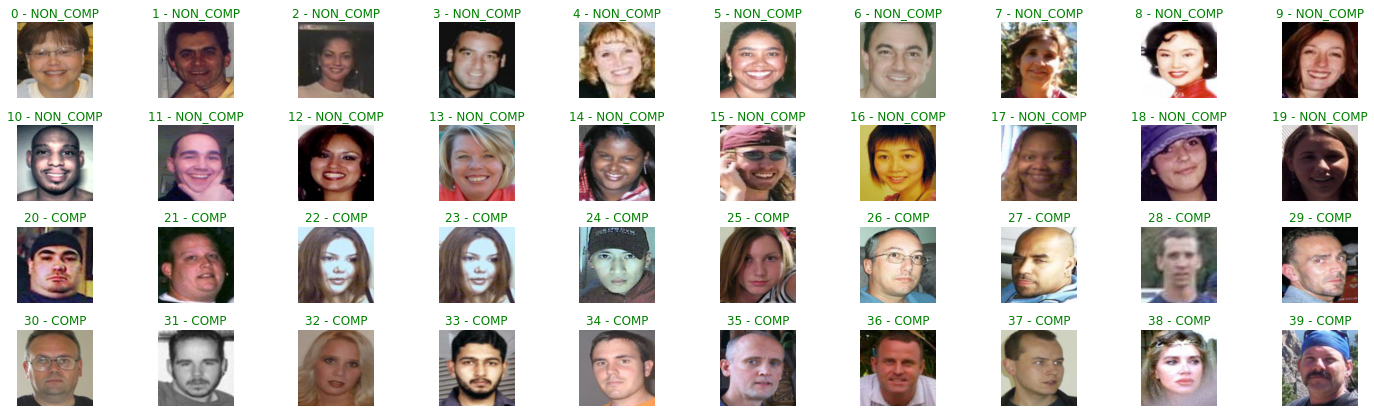

In [14]:
imgs_list_1 = [cv2.imread(img) for img in in_data.img_name.values[:20]]
imgs_list_2 = [cv2.imread(img) for img in in_data.img_name.values[-20:]]

labels_list_1 = ['COMP' if x == 1 else 'NON_COMP' for x in in_data.comp.values[:20]]
labels_list_2 = ['COMP' if x == 1 else 'NON_COMP' for x in in_data.comp.values[-20:]]

fig = dr.draw_imgs(imgs_list = imgs_list_1+imgs_list_2, 
                   labels = labels_list_1+labels_list_2, 
                   predictions = labels_list_1+labels_list_2)

# Create Model

In [15]:
baseModel, headModel = None, None
        
W,H = (224,224)

baseModel = VGG16(weights="imagenet", include_top=True, input_tensor=Input(shape=(W,H,3)), input_shape=(W,H,3))

initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1e-4, seed=42)

headModel = baseModel.output
headModel = Flatten(name="flatten2")(headModel)
headModel = Dense(128, activation="relu", kernel_initializer=initializer)(headModel)
# headModel = Dropout(0.25)(headModel)
headModel = Dense(2, activation="softmax", kernel_initializer=initializer)(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

baseModel.get_layer('fc1').trainable = True
baseModel.get_layer('fc2').trainable = True

print(model.summary())    
    
opt = SGD(lr=1e-3, decay=5*1e-5, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["acc"])

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

# Train Model

In [16]:
H = model.fit(  train_gen,
                steps_per_epoch=train_gen.n // 64,
                validation_data=validation_gen,
                validation_steps=validation_gen.n // 64,
                epochs=30)

Epoch 1/30
53/53 [==============================] - 8s 158ms/step - loss: 0.6931 - acc: 0.5341 - val_loss: 0.6931 - val_acc: 0.5531
Epoch 2/30
53/53 [==============================] - 8s 151ms/step - loss: 0.6931 - acc: 0.5308 - val_loss: 0.6931 - val_acc: 0.5531
Epoch 3/30
53/53 [==============================] - 8s 152ms/step - loss: 0.6931 - acc: 0.5341 - val_loss: 0.6931 - val_acc: 0.5531
Epoch 4/30
53/53 [==============================] - 8s 151ms/step - loss: 0.6931 - acc: 0.5338 - val_loss: 0.6931 - val_acc: 0.5562
Epoch 5/30
53/53 [==============================] - 8s 152ms/step - loss: 0.6931 - acc: 0.5314 - val_loss: 0.6931 - val_acc: 0.5531
Epoch 6/30
53/53 [==============================] - 8s 152ms/step - loss: 0.6931 - acc: 0.5346 - val_loss: 0.6931 - val_acc: 0.5531
Epoch 7/30
53/53 [==============================] - 8s 152ms/step - loss: 0.6931 - acc: 0.5329 - val_loss: 0.6931 - val_acc: 0.5531
Epoch 8/30
53/53 [==============================] - 8s 152ms/step - loss: 0.

# Draw Training

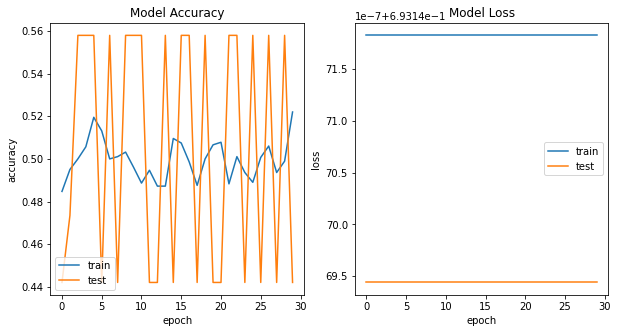

In [10]:
f,ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(H.history['accuracy'])
ax[0].plot(H.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'])

ax[1].plot(H.history['loss'])
ax[1].plot(H.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'])

plt.show()

# Test Model

In [ ]:
print("Testing Trained Model")
predIdxs = model.predict(test_gen, batch_size=64)
y_hat = np.argmax(predIdxs, axis=1)
print(classification_report(test_gen.labels, y_hat, target_names=['NON_COMP','COMP']))
print(f'Model Accuracy: {round(accuracy_score(test_gen.labels, y_hat), 4)}') 

# Evaluate Model

In [ ]:
print('Evaluating model')
eval_metrics = model.evaluate(test_gen, verbose=0)
print(f'loss: ', round(eval_metrics[0], 4))
print(f'accuracy: ', round(eval_metrics[1], 4))

# GradCam

In [ ]:
def __calc_heatmap(img_name):
    image = load_img(img_name, target_size=(224,224))
    img_tensor = img_to_array(image)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor = prep_input_vgg19(img_tensor)

    last_conv_layer_name = [l.name for l in model.layers if isinstance(l, tf.python.keras.layers.convolutional.Conv2D)][-1]

    conv_layer = model.get_layer(last_conv_layer_name)
    heatmap_model = models.Model([model.inputs], [conv_layer.output, model.output])

    # Get gradient of the winner class w.r.t. the output of the (last) conv. layer
    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        loss = predictions[:, np.argmax(predictions[0])]
        grads = gtape.gradient(loss, conv_output)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # Channel-wise mean of resulting feature-map is the heatmap of class activation
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    # Render heatmap via pyplot
    # plt.imshow(heatmap[0])
    # plt.show()

    upsample = cv2.resize(heatmap[0], (224,224))
    return upsample


preds = np.argmax(model.predict(test_gen), axis=1)
cnt = 0
for idx,_ in test_df.iterrows():
    test_df.loc[idx, 'pred'] = preds[cnt]
    cnt += 1

tmp_df = test_df.sample(n = 50, random_state=42)

def get_img_name(img_path):
    return img_path.split("/")[-1].split(".")[0]

labels = [f'COMP\n {get_img_name(path)}' if x == Eval.COMPLIANT.value else f'NON_COMP\n {get_img_name(path)}' for x,path in zip(tmp_df.comp.values, tmp_df.img_name.values)]
preds = [f'COMP\n {get_img_name(path)}' if x == Eval.COMPLIANT.value else f'NON_COMP\n {get_img_name(path)}' for x,path in zip(tmp_df.pred.values, tmp_df.img_name.values)]
heatmaps = [__calc_heatmap(im_name) for im_name in tmp_df.img_name.values]

f = dr.draw_imgs([cv2.imread(img) for img in tmp_df.img_name.values], labels=labels, predictions=preds, heatmaps=heatmaps)